In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [3]:
def peak_eV_nm(peak_eV):
    return 1239.84193/peak_eV

In [4]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [5]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), UV Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Decision tree regression models as optimized in Hyperparameter tuning
regressor_peak = DecisionTreeRegressor(max_depth=18, 
                                       min_samples_split=2, 
                                       min_samples_leaf=1, 
                                       max_features = 5,
                                       random_state=0)
regressor_fwhm = DecisionTreeRegressor(max_depth=18, 
                                       min_samples_split=13, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)
regressor_cascade = DecisionTreeRegressor(max_depth=19, 
                                       min_samples_split=12, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV): \t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

#np.savetxt("Tree_UV_Val_peak.csv", matrix, delimiter=",")
#np.savetxt("Tree_UV_Val_fwhm.csv", matrix_fwhm, delimiter=",")
#np.savetxt("Tree_UV_Val_cascade.csv", matrix_cascade, delimiter=",")

Absorbance Peak
MAE (eV): 	 0.0280 0.0030
R2 (eV):	 0.9368 0.0208
RAE (eV):	 0.1865 0.0257
RMSE (eV):	 0.0443 0.0064
Importances	 [0.12521 0.17517 0.22622 0.07805 0.39535]
MAE (nm):	 5.8817 0.6352
R2 (nm):	 0.9313 0.0259
RAE (nm):	 0.1873 0.0265
RMSE (nm):	 9.5160 1.6102
Absorbance FWHM (direct)
MAE (eV):	 0.0096 0.0007
R2 (eV):	 0.6375 0.0586
RAE (eV):	 0.4887 0.0430
RMSE (eV):	 0.0149 0.0016
Importances	 [0.11915 0.22246 0.22534 0.16375 0.2693 ]
MAE (nm):	 2.3960 0.2310
R2 (nm):	 0.6500 0.0688
RAE (nm):	 0.4688 0.0516
RMSE (nm):	 3.6404 0.4699
Absorbance FWHM (cascade)
MAE (eV):	 0.0089 0.0009
R2 (eV):	 0.6896 0.0871
RAE (eV):	 0.4528 0.0406
RMSE (eV):	 0.0138 0.0025
Importances	 [0.04718 0.13802 0.20992 0.12127 0.20181 0.28181]
MAE (nm):	 2.1492 0.2773
R2 (nm):	 0.6945 0.0943
RAE (nm):	 0.4196 0.0521
RMSE (nm):	 3.3911 0.6778


In [6]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), PL Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Decision tree models as optimized in Hyperparameter tuning
regressor_peak = DecisionTreeRegressor(max_depth=17, 
                                       min_samples_split=2, 
                                       min_samples_leaf=1, 
                                       max_features = 5,
                                       random_state=0)
regressor_fwhm = DecisionTreeRegressor(max_depth=16, 
                                       min_samples_split=3, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)
regressor_cascade = DecisionTreeRegressor(max_depth=15, 
                                       min_samples_split=20, 
                                       min_samples_leaf=8, 
                                       max_features = 5,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

#np.savetxt("Tree_PL_Val_peak.csv", matrix, delimiter=",")
#np.savetxt("Tree_PL_Val_fwhm.csv", matrix_fwhm, delimiter=",")
#np.savetxt("Tree_PL_Val_cascade.csv", matrix_cascade, delimiter=",")

Emission Peak
MAE (eV):	 0.0217 0.0032
R2 (eV):	 0.9560 0.0170
RAE (eV):	 0.1693 0.0236
RMSE (eV):	 0.0312 0.0056
Importances	 [0.12221 0.19753 0.267   0.08167 0.33159]
MAE (nm):	 4.8424 0.6839
R2 (nm):	 0.9565 0.0165
RAE (nm):	 0.1686 0.0232
RMSE (nm):	 6.9028 1.2308
Emission FWHM (direct)
MAE (eV):	 0.0092 0.0008
R2 (eV):	 0.5528 0.0865
RAE (eV):	 0.5704 0.0401
RMSE (eV):	 0.0137 0.0013
Importances	 [0.14973 0.21523 0.20238 0.1561  0.27656]
MAE (nm):	 2.2410 0.1597
R2 (nm):	 0.6433 0.0747
RAE (nm):	 0.5148 0.0242
RMSE (nm):	 3.3149 0.2374
Emission FWHM (cascade)
MAE (eV):	 0.0081 0.0008
R2 (eV):	 0.6180 0.0891
RAE (eV):	 0.5066 0.0438
RMSE (eV):	 0.0126 0.0014
Importances	 [0.0666  0.0626  0.22398 0.1441  0.03789 0.46483]
MAE (nm):	 1.9568 0.1359
R2 (nm):	 0.7060 0.0690
RAE (nm):	 0.4504 0.0341
RMSE (nm):	 3.0049 0.2460


In [7]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Decision tree regression models as optimized in Hyperparameter tuning
regressor_peak = DecisionTreeRegressor(max_depth=18, 
                                       min_samples_split=2, 
                                       min_samples_leaf=1, 
                                       max_features = 5,
                                       random_state=0)
regressor_fwhm = DecisionTreeRegressor(max_depth=18, 
                                       min_samples_split=13, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)
regressor_cascade = DecisionTreeRegressor(max_depth=19, 
                                       min_samples_split=12, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))


Absorption Peak/FWHM Training Accuracy
Absorbance Peak
MAE (eV):	 0.0004
R2 (eV):	 0.9996
RAE (eV):	 0.0028
RMSE (eV):	 0.0034
Importances	 [0.1258  0.17393 0.22792 0.0774  0.39495]
MAE (nm):	 0.0884
R2 (nm):	 0.9997
RAE (nm):	 0.0028
RMSE (nm):	 0.6934
Absorbance FWHM (direct)
MAE (eV):	 0.0054
R2 (eV):	 0.8509
RAE (eV):	 0.2716
RMSE (eV):	 0.0097
Importances	 [0.08525 0.19618 0.23663 0.20558 0.27636]
MAE (nm):	 1.2472
R2 (nm):	 0.8711
RAE (nm):	 0.2390
RMSE (nm):	 2.2521
Absorbance FWHM (cascade)
MAE (eV):	 0.0044
R2 (eV):	 0.8857
RAE (eV):	 0.2227
RMSE (eV):	 0.0085
Importances	 [0.04625 0.09532 0.22691 0.12829 0.19748 0.30575]
MAE (nm):	 1.0243
R2 (nm):	 0.9044
RAE (nm):	 0.1963
RMSE (nm):	 1.9400


In [8]:
#Test Linear model on interpolation, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

#np.savetxt("Tree_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
#np.savetxt("Tree_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
#np.savetxt("Tree_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation
Absorbance Peak
MAE (eV):	 0.0618
R2 (eV):	 0.7468
RAE (eV):	 0.4689
RMSE (eV):	 0.0796
MAE (nm):	 12.4452
R2 (nm):	 0.7768
RAE (nm):	 0.4413
RMSE (nm):	 15.7295
Absorbance FWHM (direct)
MAE (eV):	 0.0128
R2 (eV):	 0.5704
RAE (eV):	 0.6418
RMSE (eV):	 0.0162
MAE (nm):	 2.4324
R2 (nm):	 0.7166
RAE (nm):	 0.4511
RMSE (nm):	 3.3569
Absorbance FWHM (cascade)
MAE (eV):	 0.0123
R2 (eV):	 0.5262
RAE (eV):	 0.6199
RMSE (eV):	 0.0170
MAE (nm):	 2.2901
R2 (nm):	 0.7283
RAE (nm):	 0.4247
RMSE (nm):	 3.2868


array([[0.19717, 0.1846 , 0.17567, 0.1725 , ..., 0.17873, 0.17873,
        0.17873, 0.17873]])

In [9]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

#np.savetxt("Tree_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
#np.savetxt("Tree_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
#np.savetxt("Tree_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation
Absorbance Peak
MAE (eV):	 0.0437
R2 (eV):	 0.9070
RAE (eV):	 0.2639
RMSE (eV):	 0.0607
MAE (nm):	 8.7097
R2 (nm):	 0.9206
RAE (nm):	 0.2459
RMSE (nm):	 11.7979
Absorbance FWHM (direct)
MAE (eV):	 0.0112
R2 (eV):	 0.7654
RAE (eV):	 0.4159
RMSE (eV):	 0.0153
MAE (nm):	 2.6948
R2 (nm):	 0.5394
RAE (nm):	 0.5969
RMSE (nm):	 3.5684
Absorbance FWHM (cascade)
MAE (eV):	 0.0125
R2 (eV):	 0.7025
RAE (eV):	 0.4624
RMSE (eV):	 0.0172
MAE (nm):	 2.6130
R2 (nm):	 0.5125
RAE (nm):	 0.5788
RMSE (nm):	 3.6711


array([[0.16414, 0.16767, 0.16467, 0.15071, ..., 0.1655 , 0.1605 ,
        0.15443, 0.15443]])

In [10]:
# load dataset into Pandas DataFrame
test1 = pd.read_csv('testpoints1.csv')
test2 = pd.read_csv('testpoints2.csv')

test1 = test1[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
test2 = test2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]

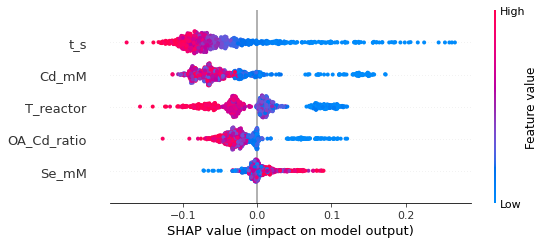

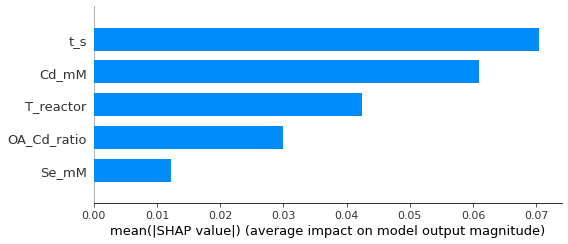

In [11]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
#np.savetxt("Tree_UV_peak_shap.csv", shap_values, delimiter=",")

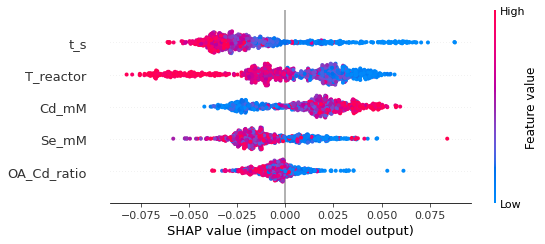

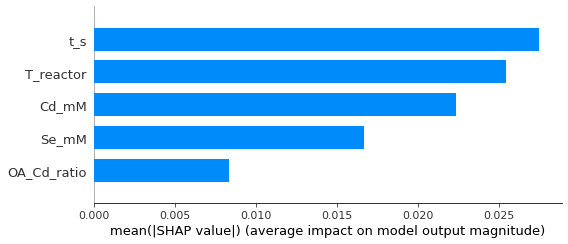

In [12]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
#np.savetxt("Tree_UV_fwhm_shap.csv", shap_values, delimiter=",")

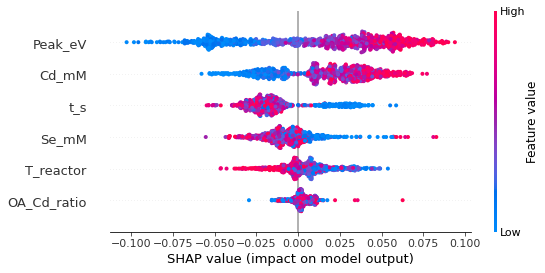

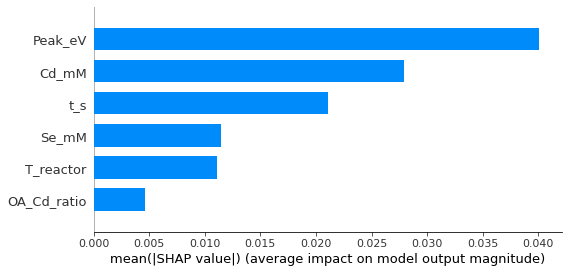

In [13]:

#SHAP on training data for Cascade
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(test2)
shap.summary_plot(shap_values, test2)
shap.summary_plot(shap_values, test2, plot_type="bar")
#np.savetxt("Tree_UV_cascade_shap.csv", shap_values, delimiter=",")

In [14]:
#Train model on entire dataset (Emission)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Decision tree models as optimized in Hyperparameter tuning
regressor_peak = DecisionTreeRegressor(max_depth=17, 
                                       min_samples_split=2, 
                                       min_samples_leaf=1, 
                                       max_features = 5,
                                       random_state=0)
regressor_fwhm = DecisionTreeRegressor(max_depth=16, 
                                       min_samples_split=3, 
                                       min_samples_leaf=6, 
                                       max_features = 4,
                                       random_state=0)
regressor_cascade = DecisionTreeRegressor(max_depth=15, 
                                       min_samples_split=20, 
                                       min_samples_leaf=8, 
                                       max_features = 5,
                                       random_state=0)
matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Emission Peak/FWHM Training Accuracy
Emission Peak
MAE (eV):	 0.0004
R2 (eV):	 0.9996
RAE (eV):	 0.0029
RMSE (eV):	 0.0029
Importances	 [0.12235 0.1968  0.26834 0.08189 0.33061]
MAE (nm):	 0.0821
R2 (nm):	 0.9997
RAE (nm):	 0.0028
RMSE (nm):	 0.6340
Emission FWHM (direct)
MAE (eV):	 0.0054
R2 (eV):	 0.8121
RAE (eV):	 0.3349
RMSE (eV):	 0.0090
Importances	 [0.13647 0.20304 0.17398 0.19666 0.28985]
MAE (nm):	 1.2880
R2 (nm):	 0.8655
RAE (nm):	 0.2929
RMSE (nm):	 2.0847
Emission FWHM (cascade)
MAE (eV):	 0.0046
R2 (eV):	 0.8719
RAE (eV):	 0.2842
RMSE (eV):	 0.0074
Importances	 [0.08066 0.06725 0.20418 0.16043 0.03105 0.45643]
MAE (nm):	 1.1279
R2 (nm):	 0.8975
RAE (nm):	 0.2565
RMSE (nm):	 1.8201


In [15]:
#Test Linear model on interpolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

#np.savetxt("Tree_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
#np.savetxt("Tree_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
#np.savetxt("Tree_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Interpolation
Emission Peak
MAE (eV):	 0.0527
R2 (eV):	 0.7914
RAE (eV):	 0.4385
RMSE (eV):	 0.0649
MAE (nm):	 11.5393
R2 (nm):	 0.8136
RAE (nm):	 0.4194
RMSE (nm):	 13.8436
Emission FWHM (direct)
MAE (eV):	 0.0111
R2 (eV):	 0.4967
RAE (eV):	 0.6538
RMSE (eV):	 0.0165
MAE (nm):	 2.7775
R2 (nm):	 0.6039
RAE (nm):	 0.5881
RMSE (nm):	 3.8227
Emission FWHM (cascade)
MAE (eV):	 0.0112
R2 (eV):	 0.5322
RAE (eV):	 0.6565
RMSE (eV):	 0.0159
MAE (nm):	 2.7335
R2 (nm):	 0.6495
RAE (nm):	 0.5788
RMSE (nm):	 3.5960


array([[0.147  , 0.1408 , 0.16025, 0.18353, ..., 0.13183, 0.13183,
        0.13183, 0.13183]])

In [16]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

#np.savetxt("Tree_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
#np.savetxt("Tree_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
#np.savetxt("Tree_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Extrapolation
Emission Peak
MAE (eV):	 0.0341
R2 (eV):	 0.8981
RAE (eV):	 0.2751
RMSE (eV):	 0.0463
MAE (nm):	 7.5773
R2 (nm):	 0.9122
RAE (nm):	 0.2604
RMSE (nm):	 10.0349
Emission FWHM (direct)
MAE (eV):	 0.0101
R2 (eV):	 0.5255
RAE (eV):	 0.5730
RMSE (eV):	 0.0140
MAE (nm):	 2.4630
R2 (nm):	 0.4219
RAE (nm):	 0.6584
RMSE (nm):	 3.3986
Emission FWHM (cascade)
MAE (eV):	 0.0102
R2 (eV):	 0.5457
RAE (eV):	 0.5831
RMSE (eV):	 0.0137
MAE (nm):	 2.3432
R2 (nm):	 0.4921
RAE (nm):	 0.6264
RMSE (nm):	 3.1857


array([[0.1371 , 0.15925, 0.15925, 0.15925, ..., 0.14643, 0.14643,
        0.14643, 0.14643]])

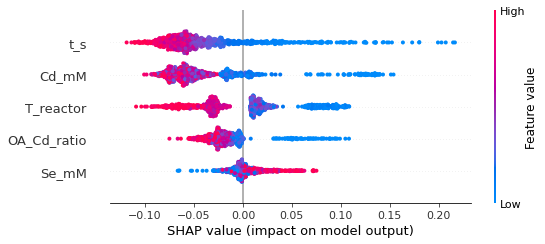

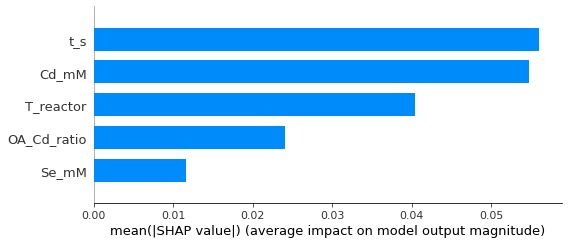

In [17]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("Tree_PL_peak_shap.csv", shap_values, delimiter=",")

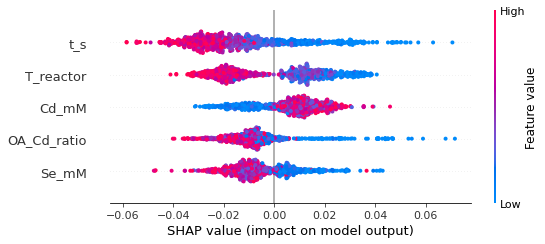

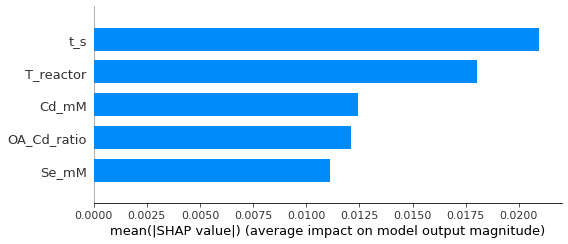

In [18]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)
shap.summary_plot(shap_values, test1, plot_type="bar")
np.savetxt("Tree_PL_fwhm_shap.csv", shap_values, delimiter=",")

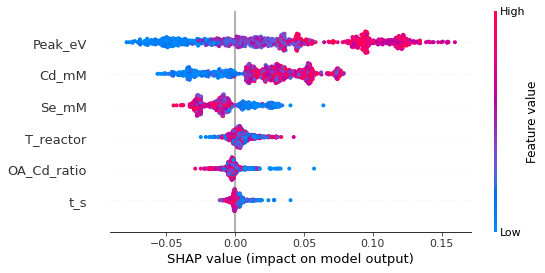

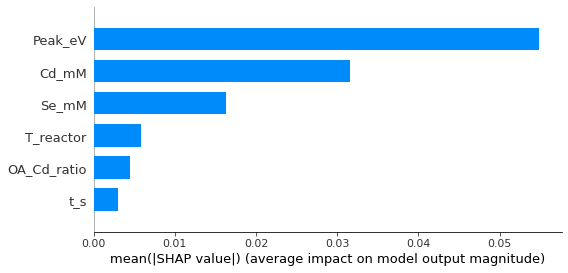

In [19]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(test2)
shap.summary_plot(shap_values, test2)
shap.summary_plot(shap_values, test2, plot_type="bar")
np.savetxt("Tree_PL_cascade_shap.csv", shap_values, delimiter=",")

In [20]:
np.shape(shap_values)

(1000, 6)